<a href="https://colab.research.google.com/github/KAFE45/Colab-LabBCI/blob/main/EEG_PreprocessingV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **ขั้นตอน 1: ติดตั้งไลบรารีที่จำเป็น**



In [2]:
!pip install pyxdf
!pip install scipy

## **ขั้นตอนที่ 2: อัปโหลดไฟล์ XDF**






In [2]:
from google.colab import files

# อัปโหลดไฟล์ XDF
uploaded = files.upload()

# เลือกไฟล์ XDF ที่อัปโหลด
xdf_file = list(uploaded.keys())[0]


Saving sub-Datatestcut_ses-ONLY 5 HZ_task-Default_run-001_eeg.xdf to sub-Datatestcut_ses-ONLY 5 HZ_task-Default_run-001_eeg.xdf


### **ตรวจสอบชื่อ stream ทั้งหมดในไฟล์ XDF**

In [10]:
# ตรวจสอบชื่อ stream ทั้งหมดในไฟล์ XDF
for idx, stream in enumerate(streams):
    print(f"Stream {idx}: Name - {stream['info']['name'][0]}")


Stream 0: Name - eeg


## **แยกข้อมูลจาก stream "eeg":**

In [18]:
# ใช้ stream "eeg" เป็นข้อมูลสัญญาณ EEG
eeg_stream = next(stream for stream in streams if 'eeg' in stream['info']['name'][0])

# ดึงข้อมูลสัญญาณ EEG และ timestamps
eeg_data = eeg_stream['time_series']  # รูปแบบ (number_of_samples, number_of_channels)
eeg_time_stamps = eeg_stream['time_stamps']

# ตรวจสอบข้อมูล
print(f"EEG data shape: {eeg_data.shape}")
print(f"EEG timestamps: {eeg_time_stamps[:5]}")


EEG data shape: (31672, 24)
EEG timestamps: [3731.34393761 3731.34784386 3731.35175011 3731.35565636 3731.35956261]


In [ ]:
# ตรวจสอบโครงสร้างของข้อมูลใน eeg_stream['info']
import pprint
pprint.pprint(eeg_stream['info'])


## **ขั้นตอนที่ 3: อ่านข้อมูลจากไฟล์ XDF**






In [19]:
import pyxdf

# อ่านข้อมูลจากไฟล์ XDF
streams, header = pyxdf.load_xdf(xdf_file)


## **ฟิลเตอร์สัญญาณ EEG: ฟิลเตอร์สัญญาณ EEG ด้วย bandpass filter เพื่อกรอง noise (เช่น 1–50 Hz):**

In [20]:
# ขั้นตอนที่ 4: กำหนด sampling rate
fs = float(eeg_stream['info']['effective_srate'])

# ขั้นตอนที่ 5: สร้าง bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

# ขั้นตอนที่ 6: ฟิลเตอร์สัญญาณ EEG
lowcut = 1.0  # ความถี่ต่ำ
highcut = 50.0  # ความถี่สูง
filtered_eeg = bandpass_filter(eeg_data, lowcut, highcut, fs)

# ตรวจสอบข้อมูลที่ฟิลเตอร์
print(f"Filtered EEG data shape: {filtered_eeg.shape}")

Filtered EEG data shape: (31672, 24)


## **ขั้นตอนที่ 6: การแบ่งข้อมูลตาม Markers**
*   คุณสามารถตัดสัญญาณ EEG เป็นช่วงๆ ตามเวลาของ markers:




In [24]:
import pyxdf
from google.colab import files
from scipy.signal import butter, filtfilt
import numpy as np

# ขั้นตอนที่ 1: อัปโหลดไฟล์ XDF
uploaded = files.upload()
xdf_file = list(uploaded.keys())[0]

# ขั้นตอนที่ 2: อ่านข้อมูลจากไฟล์ XDF
streams, header = pyxdf.load_xdf(xdf_file)

# ขั้นตอนที่ 3: แยกข้อมูล EEG
eeg_stream = next(stream for stream in streams if 'eeg' in stream['info']['name'][0])
eeg_data = eeg_stream['time_series']
eeg_time_stamps = eeg_stream['time_stamps']

# ขั้นตอนที่ 4: กำหนด sampling rate
fs = float(eeg_stream['info']['effective_srate'])

# ขั้นตอนที่ 5: สร้าง bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data, axis=0)
    return y

# ขั้นตอนที่ 6: ฟิลเตอร์สัญญาณ EEG
lowcut = 1.0  # ความถี่ต่ำ
highcut = 50.0  # ความถี่สูง
filtered_eeg = bandpass_filter(eeg_data, lowcut, highcut, fs)

# ขั้นตอนที่ 7: กำหนดช่วงเวลาเริ่มต้นและสิ้นสุด
start_time = 0  # วินาทีเริ่มต้น
end_time = 10  # วินาทีสิ้นสุด

# ขั้นตอนที่ 8: ค้นหาดัชนีที่ตรงกับช่วงเวลา
start_idx = np.argmin(np.abs(eeg_time_stamps - start_time))
end_idx = np.argmin(np.abs(eeg_time_stamps - end_time))

# ขั้นตอนที่ 9: ตัดสัญญาณตามช่วงเวลา
eeg_segment = filtered_eeg[start_idx:end_idx]

# แสดงข้อมูลที่ถูกตัด
print(f"Segment shape: {eeg_segment.shape}")


Saving sub-Datatestcut_ses-ONLY 5 HZ_task-Default_run-001_eeg.xdf to sub-Datatestcut_ses-ONLY 5 HZ_task-Default_run-001_eeg (1).xdf
Segment shape: (0, 24)


In [30]:
# กำหนดช่วงเวลาเริ่มต้นและสิ้นสุด
start_time = eeg_time_stamps[0]  # เริ่มจาก timestamp แรก
end_time = eeg_time_stamps[-1]   # สิ้นสุดที่ timestamp สุดท้าย

# ค้นหาดัชนีที่ตรงกับช่วงเวลา
start_idx = np.argmin(np.abs(eeg_time_stamps - start_time))
end_idx = np.argmin(np.abs(eeg_time_stamps - end_time))

# ตัดสัญญาณตามช่วงเวลา
eeg_segment = filtered_eeg[start_idx:end_idx]

# แสดงข้อมูลที่ถูกตัด
print(f"Segment shape: {eeg_segment.shape}")



Segment shape: (31671, 24)


In [31]:
import pandas as pd

# บันทึก segment ลงไฟล์ CSV
df_segment = pd.DataFrame(eeg_segment)
df_segment.to_csv('eeg_segment.csv', index=False)

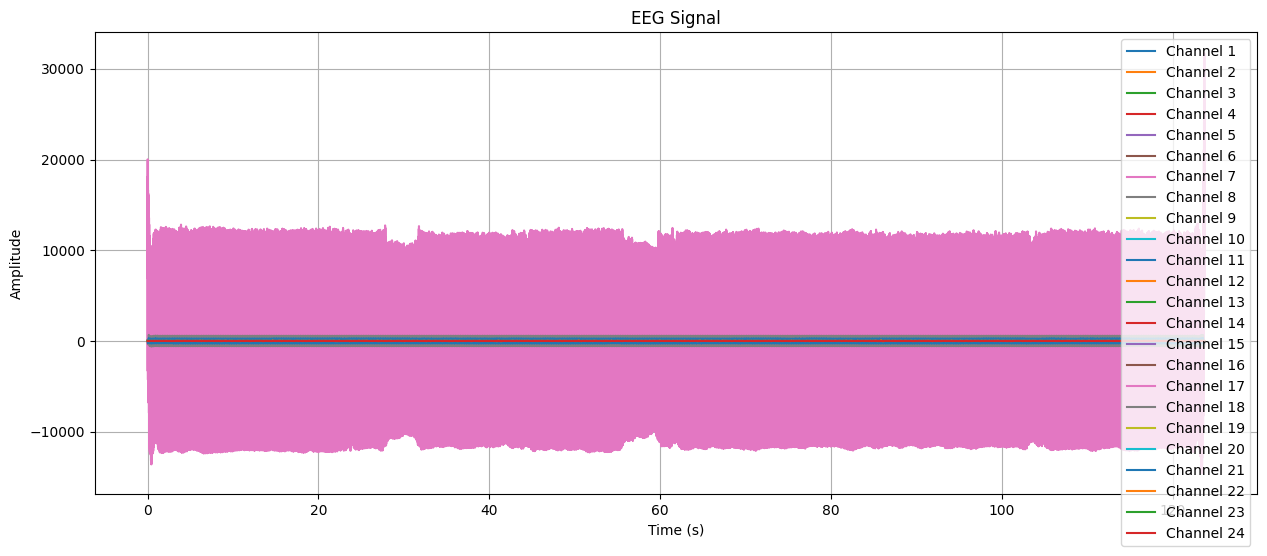

In [33]:
import matplotlib.pyplot as plt

# กำหนดเวลาแกน X ตาม sampling rate
time = np.arange(eeg_segment.shape[0]) / fs  # แปลงดัชนีเป็นเวลา

# สร้างกราฟแสดงสัญญาณ EEG
plt.figure(figsize=(15, 6))
for i in range(eeg_segment.shape[1]):  # แสดงทุกช่องสัญญาณ
    plt.plot(time, eeg_segment[:, i], label=f'Channel {i+1}')
plt.title('EEG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()


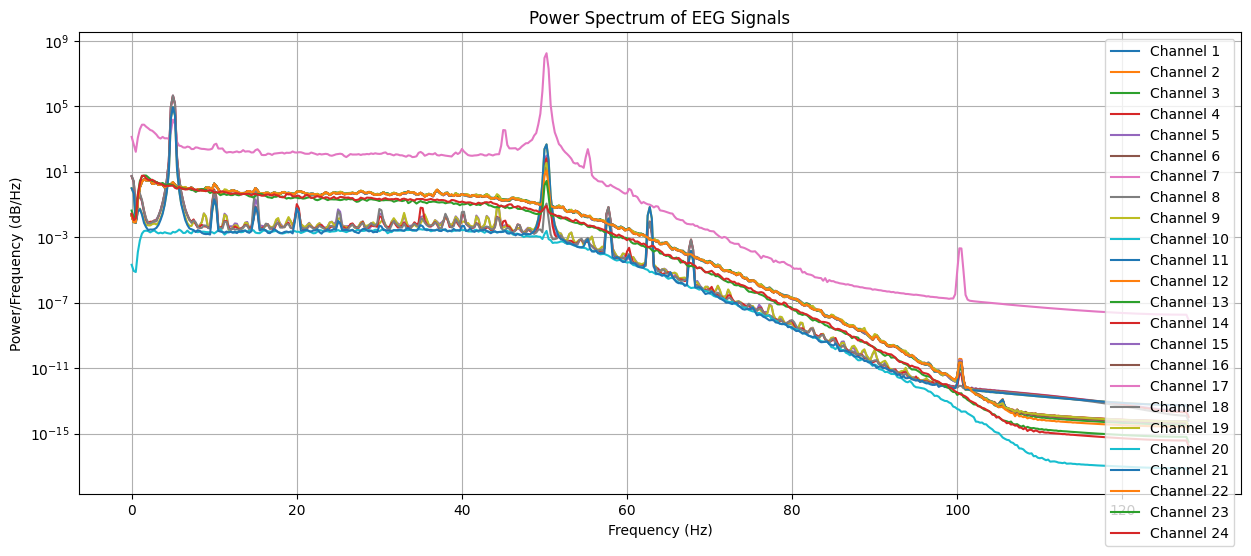

In [34]:
from scipy.signal import welch

# กำหนดความถี่ที่ต้องการ
frequencies = []
powers = []

for i in range(eeg_segment.shape[1]):  # คำนวณสำหรับทุกช่องสัญญาณ
    freq, power = welch(eeg_segment[:, i], fs=fs, nperseg=1024)
    frequencies.append(freq)
    powers.append(power)

# สร้างกราฟพลังงานในสเปกตรัม
plt.figure(figsize=(15, 6))
for i in range(len(powers)):
    plt.semilogy(frequencies[i], powers[i], label=f'Channel {i+1}')
plt.title('Power Spectrum of EEG Signals')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.legend()
plt.grid()
plt.show()


## **ขั้นตอนที่ 7: การแสดงผลข้อมูล**
*   หากคุณต้องการแสดงผลสัญญาณ EEG หรือข้อมูลที่ตัดออกมาตาม markers สามารถใช้ไลบรารีอย่าง matplotlib ได้:




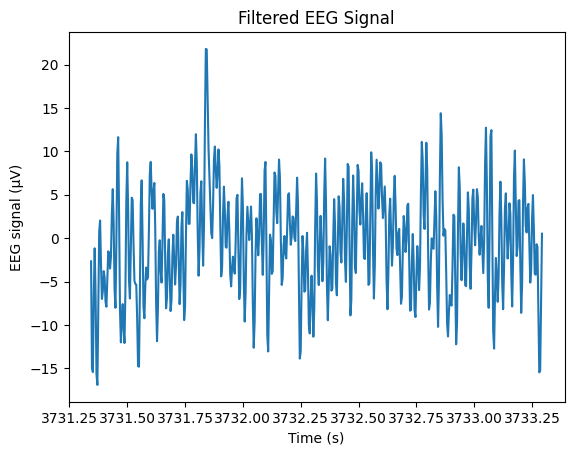

In [25]:
import matplotlib.pyplot as plt

# แสดงผลตัวอย่างของสัญญาณ EEG ที่ถูกฟิลเตอร์
plt.plot(eeg_time_stamps[:500], filtered_eeg[:500, 0])  # ตัวอย่างจากช่องที่ 1
plt.xlabel('Time (s)')
plt.ylabel('EEG signal (µV)')
plt.title('Filtered EEG Signal')
plt.show()